# A Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2012',
                                                             '31-12-2014'),
                                                            ('01-01-2015',
                                                             '31-12-2015'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 95 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

77916

# Load Pairs

In [10]:
#with open('data/etfs/pickle/2012-2016/pairs_unsupervised_learning_optical_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('data/etfs/pickle/2012-2016/pairs_unsupervised_learning_optical_intraday_p010_seed0.pickle',
          'rb') as handle:
    pairs = pickle.load(handle)

In [12]:
len(pairs)

39

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [13]:
train_val_split = '2014-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [14]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 39/39

Average SR:  1.0624676420991694
Annual ROI:  8.328461006218424
87.17948717948718 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.860289514627686
Autocorrelation:  -0.12345959933783122
Daily Sharpe Ratio 0.23427887839090314
Total number of trades:  105
Positive trades:  85
Negative trades:  20
Max DD period: 9.0 days
Maximum drawdown of portfolio: -0.97%


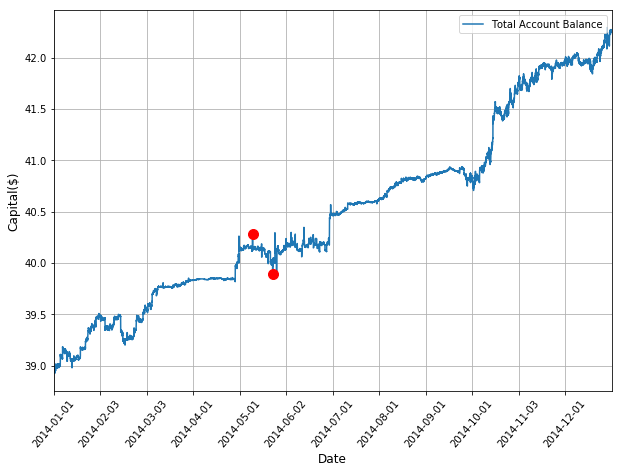

In [15]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [31]:
print('Corrected Annualized SR: {:.2f}'.format(0.23427887839090314*17.47))

Corrected Annualized SR: 4.09


Sharpe Ratio Distribution: 


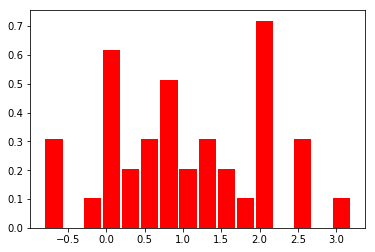

In [16]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [17]:
#cum_returns_threshold_train_w_costs

In [18]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

array([1.12915648, 1.87627629, 2.08613271, 2.0512456 , 3.46597476,
       3.40788448, 2.39499998, 0.23866385, 0.64066858, 1.29305493,
       2.44006005, 0.57269408, 1.42188649, 1.53282529, 0.15276978,
       0.86039337, 1.56169222, 0.61177178, 0.52491542, 2.01111233,
       0.8118899 , 0.57458147, 0.36114197, 0.16733541, 0.4982667 ,
       0.65434026, 0.87505032, 0.29341946, 0.32082556, 1.49623845,
       0.78900643, 0.3574557 , 1.66398157, 0.40126493, 0.54781599,
       2.01213015, 1.73921757, 1.67547829, 1.16000154])

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [19]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [20]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 39/39

Average SR:  1.3988286007466202
Annual ROI:  12.50758582074294
82.05128205128206 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.760553319071313
Autocorrelation:  0.11122689215727358
Daily Sharpe Ratio 0.28333093095741857
Total number of trades:  161
Positive trades:  140
Negative trades:  21
Max DD period: 2.0 days
Maximum drawdown of portfolio: -1.37%


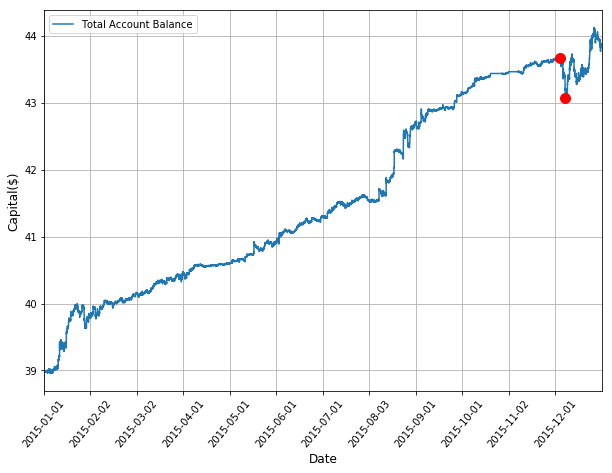

In [21]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [32]:
print('Corrected Annualized SR: {:.2f}'.format(0.28333093095741857*14.31))

Corrected Annualized SR: 4.05


### Approach 2: Keeping only pairs that had positive returns in the training period

In [22]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [23]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 34/34

Average SR:  1.4796935007848417
Annual ROI:  13.487481488549747
82.3529411764706 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.525506024550783
Autocorrelation:  0.11787863638192095
Daily Sharpe Ratio 0.2682868800357132
Total number of trades:  147
Positive trades:  128
Negative trades:  19
Max DD period: 4.0 days
Maximum drawdown of portfolio: -1.66%


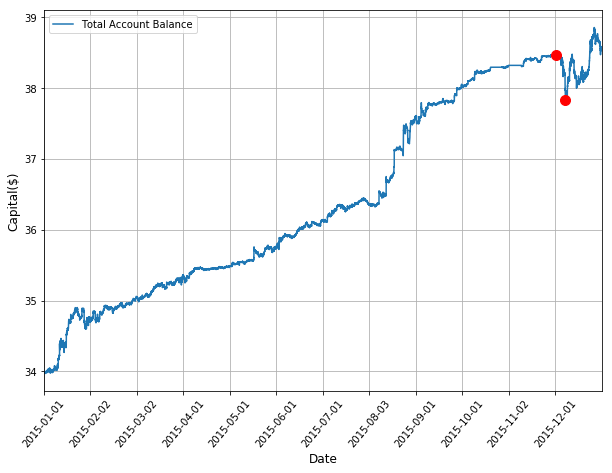

In [24]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [33]:
print('Corrected Annualized SR: {:.2f}'.format(0.2682868800357132*14.31))

Corrected Annualized SR: 3.84


### Approach 3: Keeping only top 10 pairs

In [25]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [26]:
# sorting by returns seems to give better results

In [27]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [28]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 10/10

Average SR:  2.374972852002702
Annual ROI:  23.530629848764395
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  5.627890895096311
Autocorrelation:  0.021548186851439048
Daily Sharpe Ratio 0.31977595216803717
Total number of trades:  68
Positive trades:  61
Negative trades:  7
Max DD period: 0.0 days
Maximum drawdown of portfolio: -1.30%


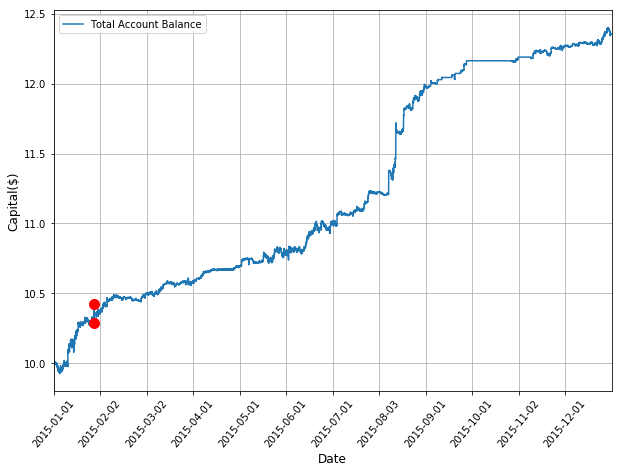

In [29]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  n_years_test)

In [34]:
print('Corrected Annualized SR: {:.2f}'.format(0.31977595216803717*(252**0.5)))

Corrected Annualized SR: 5.08


# Validate the results

In [35]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,BCM,Commodities: Broad Market,DJCI,Commodities: Broad Market,-3.771536,0.003212,392,111,0.297978,17,2,4.151694,89.473684
1,DBE,Commodities: Energy,BNO,Commodities: Energy Crude Oil,-2.791845,0.059448,653,450,0.241574,14,2,4.007704,87.500000
2,BCM,Commodities: Broad Market,SOYB,Commodities: Agriculture Soybeans,-2.617143,0.089506,161,818,0.345431,4,0,3.166795,100.000000
3,SOYB,Commodities: Agriculture Soybeans,UCI,Commodities: Broad Market,-2.582368,0.096696,283,603,0.306184,6,0,2.753426,100.000000
4,DJCI,Commodities: Broad Market,SOYB,Commodities: Agriculture Soybeans,-2.767749,0.063030,279,686,0.324227,5,0,2.750539,100.000000
5,DBS,Commodities: Precious Metals Silver,DGP,Leveraged Commodities: Precious Metals Gold,-3.244352,0.017557,544,546,0.372660,6,0,2.725403,100.000000
6,GCC,Commodities: Broad Market,SOYB,Commodities: Agriculture Soybeans,-2.640207,0.084969,364,922,0.337939,3,0,2.031009,100.000000
7,CORN,Commodities: Agriculture Corn,SOYB,Commodities: Agriculture Soybeans,-2.748257,0.066053,308,732,0.338427,1,0,1.106109,100.000000
8,CORN,Commodities: Agriculture Corn,WEAT,Commodities: Agriculture Wheat,-3.075674,0.028407,479,530,0.316719,3,0,0.999377,100.000000
9,DBP,Commodities: Precious Metals,IAU,Commodities: Precious Metals Gold,-3.441810,0.009614,1277,93,0.214137,2,3,0.057674,40.000000
